In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
distritos = pd.read_csv('data/merged_data.csv')
almacenes = pd.read_csv('data/almacenes_heladas.csv')

In [3]:
distritos['Departamento'].value_counts()

PUNO            36
CUSCO           32
AREQUIPA        11
HUANCAVELICA     9
APURIMAC         9
HUANUCO          4
AYACUCHO         3
PASCO            2
TACNA            1
Name: Departamento, dtype: int64

In [4]:
almacenes['Departamento'].value_counts()

PUNO            16
AREQUIPA         8
HUANUCO          8
LIMA             8
CUSCO            6
APURIMAC         6
TACNA            6
MOQUEGUA         6
AYACUCHO         4
ICA              4
ANCASH           4
HUANCAVELICA     4
JUNIN            3
PASCO            3
Name: Departamento, dtype: int64

In [6]:
depts = set(distritos['Departamento'].unique())

In [7]:
almacenes['Nivel'] = almacenes['Departamento'].apply(lambda x: 1 if x in depts else 0)

In [10]:
tambos = set(distritos['DISTRITO'].unique())

In [12]:
distritos['Nivel'] = distritos['Distrito'].apply(lambda x: 2 if x in tambos else 3)

## Distancias

In [13]:
nivel0 = almacenes[almacenes['Nivel']==0].copy()
nivel1 = almacenes[almacenes['Nivel']==1].copy()
nivel2 = distritos[distritos['Nivel']==2].copy()
nivel3 = distritos[distritos['Nivel']==3].copy()

In [14]:
len(nivel0), len(nivel1), len(nivel2), len(nivel3)

(25, 61, 53, 54)

In [16]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

In [17]:
nivel0['id'] = list(range(len(nivel0)))
nivel1['id'] = list(range(len(nivel1)))
nivel2['id'] = list(range(len(nivel2)))
nivel3['id'] = list(range(len(nivel3)))

In [18]:
nivel0.to_csv('datasets/nivel0.csv', index=False)
nivel1.to_csv('datasets/nivel1.csv', index=False)
nivel2.to_csv('datasets/nivel2.csv', index=False)
nivel3.to_csv('datasets/nivel3.csv', index=False)

In [20]:
nivel0.set_index('id', drop=False, inplace=True)
nivel1.set_index('id', drop=False, inplace=True)
nivel2.set_index('id', drop=False, inplace=True)
nivel3.set_index('id', drop=False, inplace=True)

In [22]:
costs = [np.zeros((len(nivel0), len(nivel1))),
         np.zeros((len(nivel1), len(nivel2))),
         np.zeros((len(nivel2), len(nivel3)))]

In [24]:
for idx0, row0 in nivel0.iterrows():
    for idx1, row1 in nivel1.iterrows():
        costs[0][idx0,idx1] = haversine(row0['Longitud'], row0['Latitud'],
                                        row1['Longitud'], row1['Latitud'])

In [26]:
for idx0, row0 in nivel1.iterrows():
    for idx1, row1 in nivel2.iterrows():
        costs[1][idx0,idx1] = haversine(row0['Longitud'], row0['Latitud'],
                                        row1['Longitud'], row1['Latitud'])

In [27]:
for idx0, row0 in nivel2.iterrows():
    for idx1, row1 in nivel3.iterrows():
        costs[2][idx0,idx1] = haversine(row0['Longitud'], row0['Latitud'],
                                        row1['Longitud'], row1['Latitud'])

In [34]:
demands = [[max(1, x) for x in nivel3['Total del distrito']],
           [max(1, x) for x in nivel3['Población menor a 5 años']],
           [max(1, x) for x in nivel3['Población de 60 años a más']],
           [max(1, x) for x in nivel3['Total de viviendas por distrito']],
           [max(1, x) for x in nivel3['Total de instituciones educativas']],
           [max(1, x) for x in nivel3['Total de alumnos']]]

In [36]:
n_nodes = [len(nivel0), len(nivel1), len(nivel2), len(nivel3)]

In [38]:
total_demands = [sum(d) for d in demands]

In [39]:
total_demands

[392923, 41191, 39984, 93816, 1030, 8810]

In [40]:
from multiproduct import generate_supply_demand

In [42]:
supplies = generate_supply_demand(total_demands, n_nodes[0], factor=1)

In [45]:
total_supplies = [sum(d) for d in supplies]

In [46]:
max_flow = max(sum(total_supplies), sum(total_demands))
min_flow = min(sum(total_supplies), sum(total_demands))

In [50]:
from multiproduct import random_partition
from functools import partial
capacities = [list(np.sum(supplies, axis=0))] + \
             [random_partition(max_flow + np.random.poisson(int(0.1 * max_flow)), n, 
                 partial(np.random.poisson, lam=max_flow // n)) \
                 for n in n_nodes[1:-1]] + \
             [list(np.sum(demands, axis=0))]
for cap in capacities:
    assert min_flow <= sum(cap)

In [62]:
supplies = [s + [0] for s in supplies]

In [64]:
demands = [d + [0] for d in demands]

In [66]:
heladas = {}
heladas['nodes'] = sum(n_nodes)
heladas['items'] = len(demands)
heladas['n_nodes'] = n_nodes
heladas['supplies'] = supplies
heladas['demands'] = demands
heladas['costs'] = costs
heladas['capacities'] = capacities

In [67]:
import pickle
with open('datasets/heladas.pkl', 'wb') as f:
    pickle.dump(heladas, f, protocol=pickle.HIGHEST_PROTOCOL)

## Multiobjective GA

In [76]:
from multiproduct import run_multiobjective_GA

In [56]:
n_nodes

[25, 61, 53, 54]

In [63]:
[len(s) for s in supplies] 

[26, 26, 26, 26, 26, 26]

In [65]:
[len(d) for d in demands]

[55, 55, 55, 55, 55, 55]

In [60]:
[c.shape for c in costs]

[(25, 61), (61, 53), (53, 54)]

In [61]:
[len(c) for c in capacities]

[25, 61, 53, 54]

In [ ]:
%%time
pop, hof, log, toolbox = run_multiobjective_GA(n_nodes, supplies, demands, costs,
                                     capacities, pop_size=100, n_generations=70)

In [73]:
from multiproduct import plot_fronts, get_animation
from deap import tools

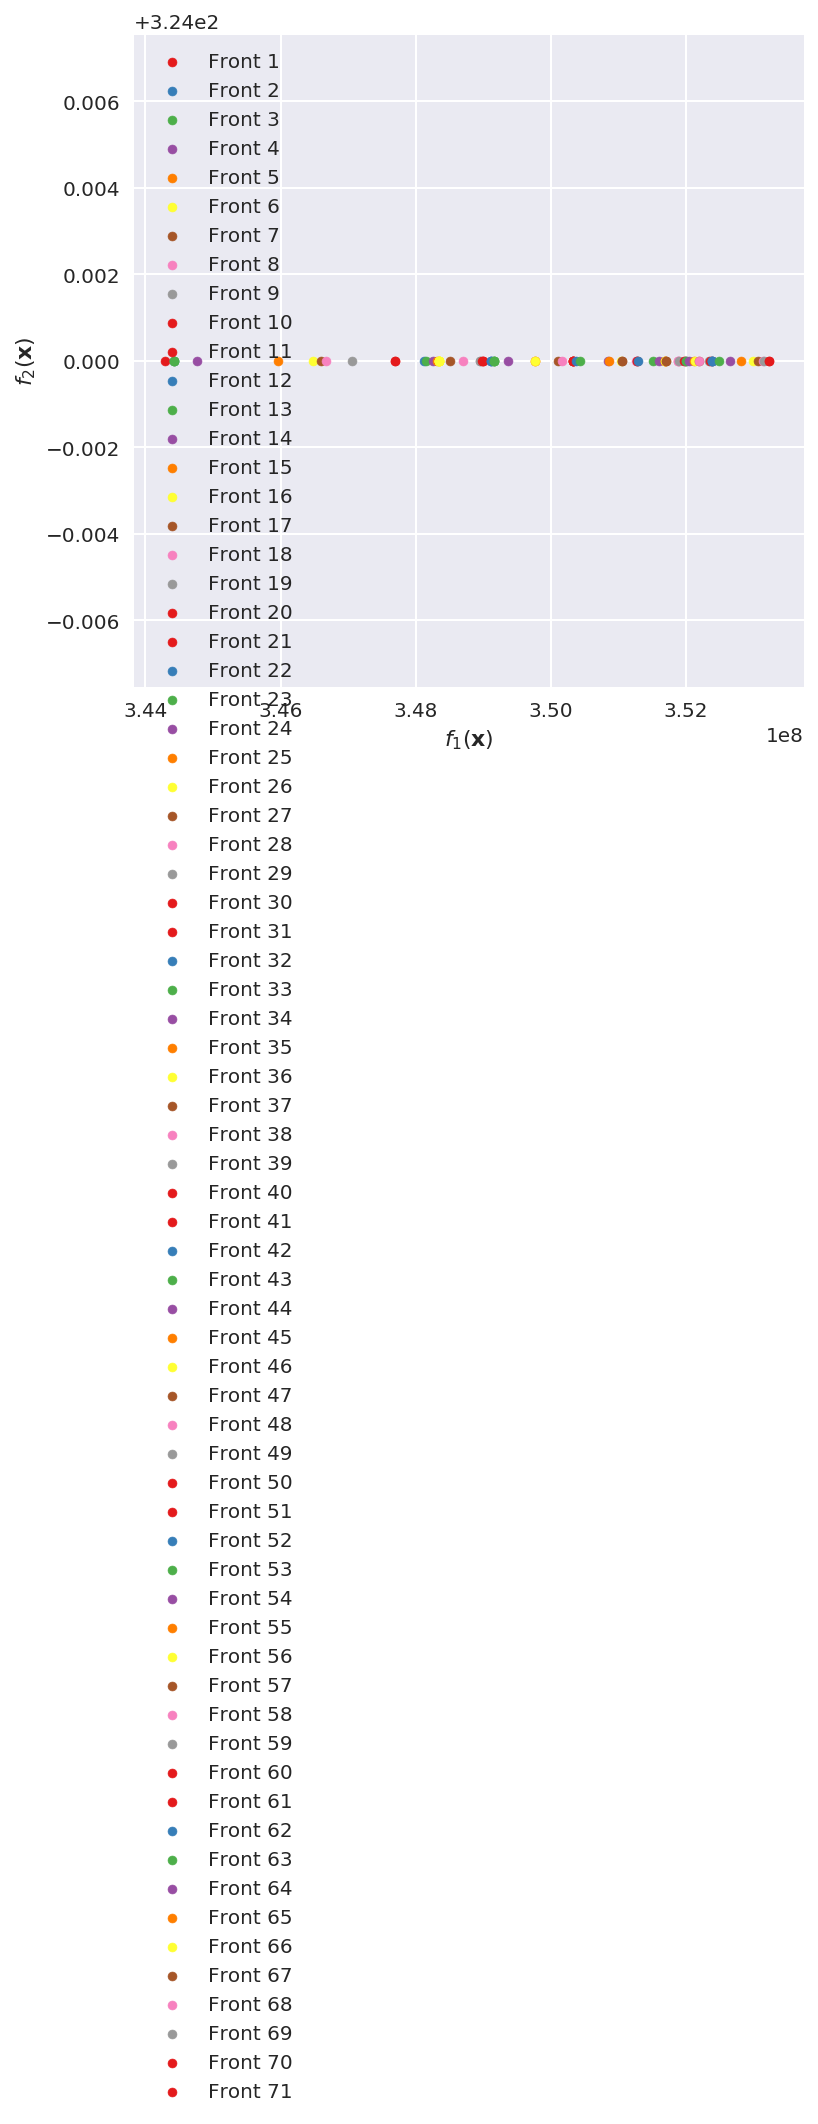

In [78]:
fronts = tools.emo.sortLogNondominated(pop, len(pop))
plot_fronts(fronts, toolbox)